<h1><center><u>Title placeholder</u></center></h1>

<h1><center><u>Introduction</u></center></h1>

<h3>Players Dataset Description</h3>

| Variable | Type   | Missing Values | Description   | Potential Issues    |
|----------|--------|----------------|---------------|---------------------|
| experience| Character (categorical)| 0 | Player's self-reported experience level:<br>Pro, Veteran, Amateur, Beginner, or Regular | Experience level does not seem to correlate with subscription status. |
| subscribe| Logical (categorical)  | 0 | Indicates whether the player has an active subscription: True or False  | There is a class imbalance in the subscribe variable. |
| hashedEmail| Character (categorical)| 0 | Anonymized, unique identifier for each player’s email address | The variable names and hashedEmails will not help in the analysis of data. |
| played_hours | Double (numerical) | 0 | Total cumulative hours the player has played to one decimal place| Many users logged very little hours played on the game, causing significant outliers.<br>Does played_hours correspond to hours played in lifetime or hours played in a single game/sitting? |
| name | Character (categorical)| 0 | The player's first name | N/A |
| gender | Character (categorical)| 0 | The player's self-reported gender:<br>Male, Female, Agender, Nonbinary, Two-spirited, Prefer not to say, or Other | Variables like Age, gender, and experience are self-reported and may be inaccurate.<br>If K-NN classification with the gender variable is used, variable type needs to be converted.  |
| Age| Double (numerical)| 2 | The player's age in years | There are 2 missing values in the Age column<br>Extreme outliers, some players have values near zero. |


<h1><center><u>Methods and Results</u></center></h1>

<h3>Reading in the Data</h3>

In [1]:
library(tidyverse)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


In [2]:
players_raw <- read.csv("https://raw.githubusercontent.com/bhallasaachi/dsci-100-2025w1-Saachi-group-45/refs/heads/main/players.csv")
players_initial <- players_raw|>
head(10)
players_initial

,experience,subscribe,hashedEmail,played_hours,name,gender,Age
,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<int>
1,Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
2,Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
3,Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
4,Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
5,Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
6,Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17
7,Regular,TRUE,8e594b8953193b26f498db95a508b03c6fe1c24bb5251d392c18a0da9a722807,0.0,Luna,Female,19
8,Amateur,FALSE,1d2371d8a35c8831034b25bda8764539ab7db0f63938696917c447128a2540dd,0.0,Emerson,Male,21
9,Amateur,TRUE,8b71f4d66a38389b7528bb38ba6eb71157733df7d1740371852a797ae97d82d1,0.1,Natalie,Male,47


<h3>Summary Stats</h3>

In [3]:
players_mean <- players_raw |>
    select(Age, played_hours)|>
    map(mean, na.rm = TRUE)
    players_mean

subscribe_percentage <- nrow(players_raw)
players_raw |>
  group_by(subscribe) |>
  summarize(count = n())

$Age
[1] 21.13918

$played_hours
[1] 5.845918

subscribe,count
<lgl>,<int>
FALSE,52
TRUE,144


<h3>Wrangling the Data for Analysis</h3>

In [27]:
players <- players_raw |>
    select(subscribe, played_hours, Age, gender) |>
    mutate(
        subscribe = as_factor(subscribe),
        gender = as_factor(gender))

glimpse(players)

Rows: 196
Columns: 4
$ subscribe    <fct> TRUE, TRUE, FALSE, TRUE, TRUE, TRUE, TRUE, FALSE, TRUE, T…
$ played_hours <dbl> 30.3, 3.8, 0.0, 0.7, 0.1, 0.0, 0.0, 0.0, 0.1, 0.0, 1.6, 0…
$ Age          <int> 9, 17, 17, 21, 21, 17, 19, 21, 47, 22, 23, 17, 25, 22, 17…
$ gender       <fct> Male, Male, Male, Female, Male, Female, Female, Male, Mal…


<h3>Visualizations</h3>

List of 1
 $ text:List of 11
  ..$ family       : NULL
  ..$ face         : NULL
  ..$ colour       : NULL
  ..$ size         : num 16
  ..$ hjust        : NULL
  ..$ vjust        : NULL
  ..$ angle        : NULL
  ..$ lineheight   : NULL
  ..$ margin       : NULL
  ..$ debug        : NULL
  ..$ inherit.blank: logi FALSE
  ..- attr(*, "class")= chr [1:2] "element_text" "element"
 - attr(*, "class")= chr [1:2] "theme" "gg"
 - attr(*, "complete")= logi FALSE
 - attr(*, "validate")= logi TRUE

Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”


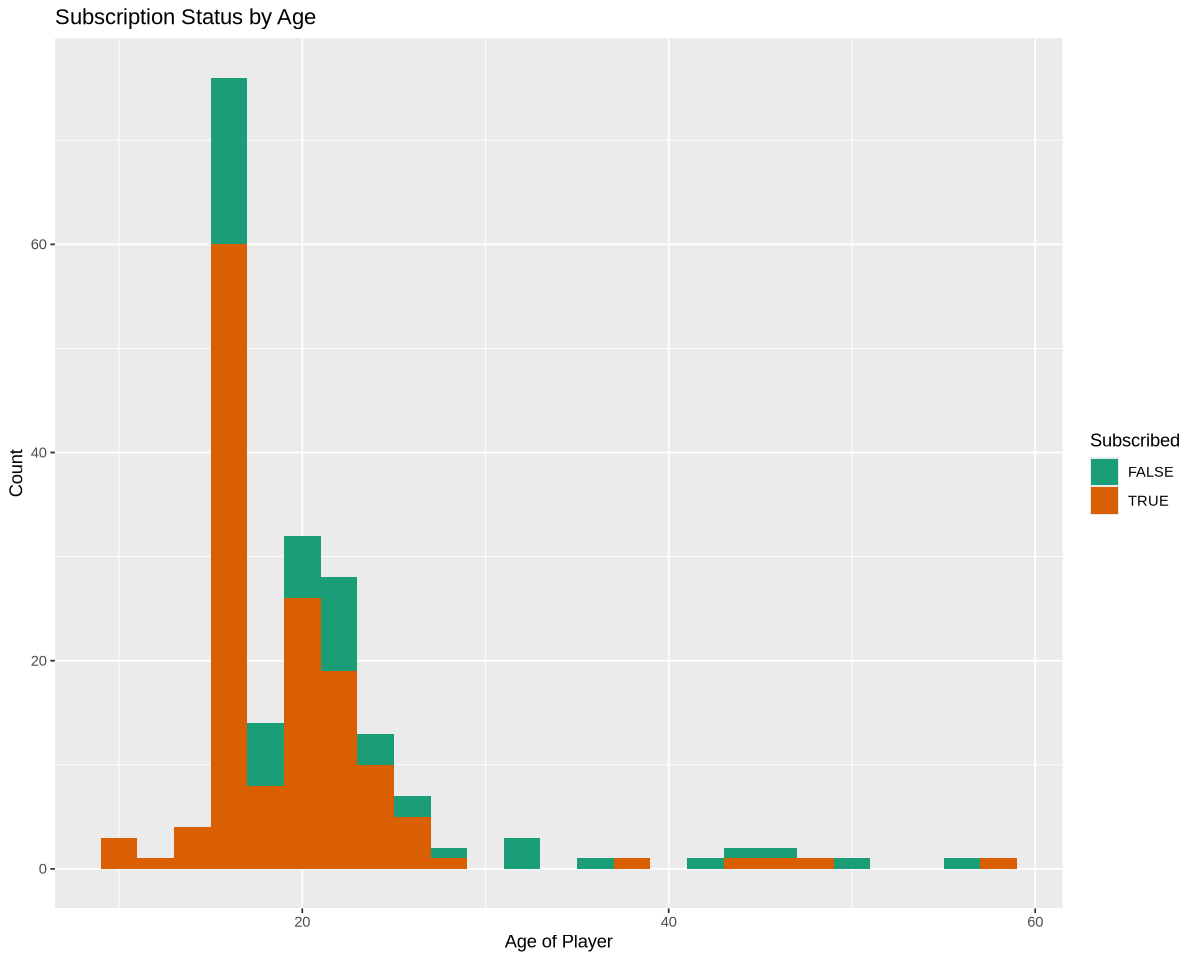

In [28]:
options(repr.plot.width = 10, repr.plot.height = 8)

age_plot <- players_raw |>
ggplot(aes(x = Age, fill = subscribe)) +
  geom_histogram(binwidth = 2) +
  scale_fill_brewer(palette = "Dark2") +
  labs(title = "Subscription Status by Age",
        x = "Age of Player",
        y = "Count",
        fill = "Subscribed")
theme(text = element_text(size = 16))

age_plot

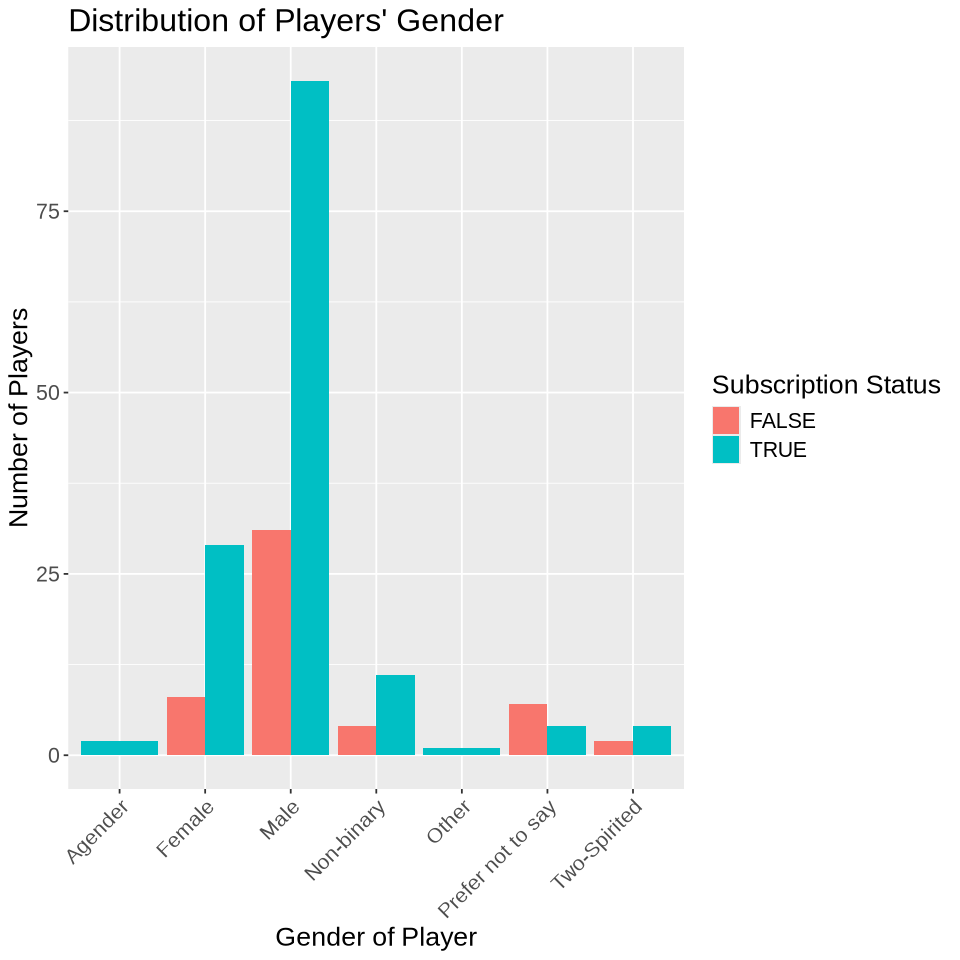

In [29]:
options(repr.plot.height = 8, repr.plot.width = 8)

gender_plot <- players_raw |>
ggplot(aes(x = gender, fill = subscribe)) +
geom_bar(position = "dodge") +
labs(x = "Gender of Player",
    y = "Number of Players",
    title = "Distribution of Players' Gender",
    fill = "Subscription Status") +
theme(axis.text.x = element_text(angle = 45, hjust = 1))+
theme(text = element_text(size = 16))
gender_plot

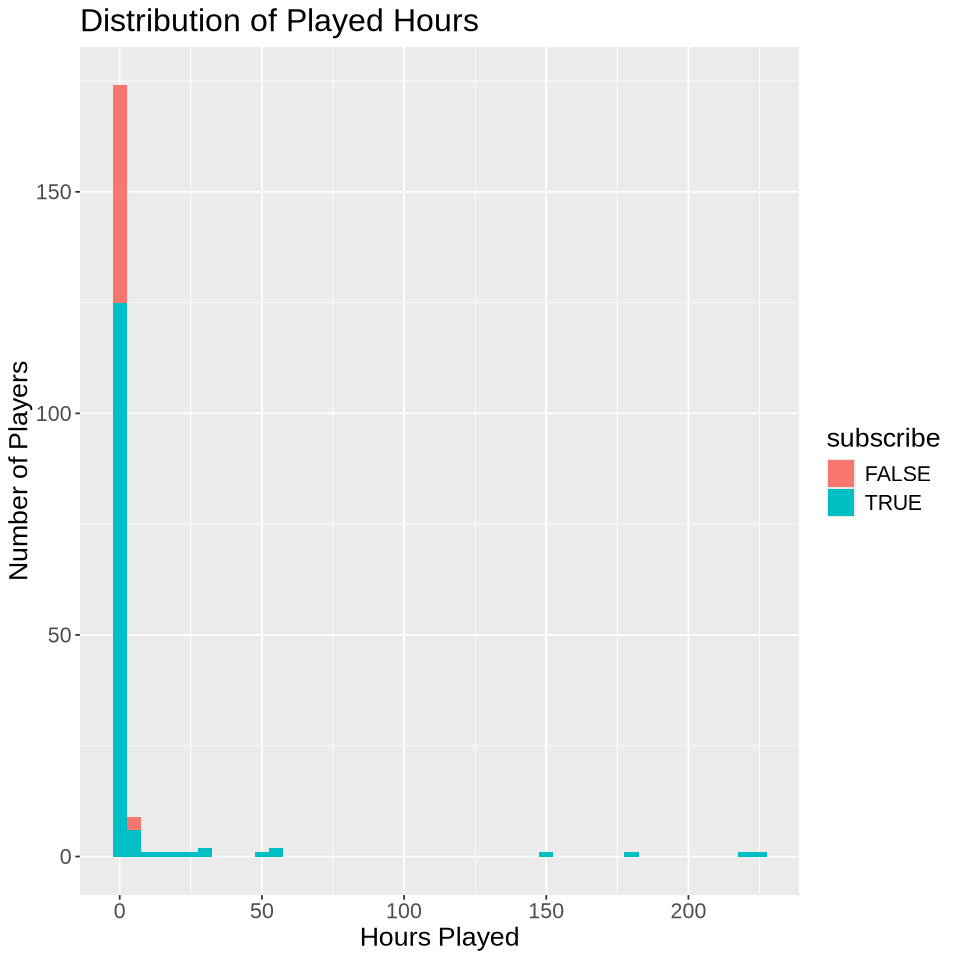

In [30]:
options(repr.plot.height = 8, repr.plot.width = 8)

hours_played_plot <- players_raw |>
ggplot(aes(x = played_hours, fill = subscribe)) +
geom_histogram(binwidth = 5) +
labs(x = "Hours Played",
       y = "Number of Players",
    title = "Distribution of Played Hours") +
theme(text = element_text(size = 16))
hours_played_plot

<h3>K-nn Classification</h3>

In [31]:
library(themis)
library(tidymodels)

set.seed(1)

---- splitting data ----

In [32]:
players_split <- initial_split(players, prop = 0.8, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

nrow(players_train)
nrow(players_test)

[1] 156

[1] 40

---- recipe, spec, and workflow ----

In [33]:
players_recipe <- recipe(subscribe ~ ., data = players_train) |>
    step_impute_mean(all_numeric_predictors()) |> # n/a age values
    step_dummy(all_nominal_predictors(), -all_outcomes()) |> # gender/experience -> numbers
    step_scale(all_predictors()) |>
    step_center(all_predictors())# |>
    #step_upsample(subscribe, over_ratio = 1, skip = FALSE) # UNCOMMENT FOR UPSAMPLING

knn_spec <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") |>
    set_engine("kknn") |>
    set_mode("classification")

knn_workflow <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(knn_spec)

---- cross-validation ----

In [34]:
players_vfold <- vfold_cv(players_train, v = 8, strata = subscribe) 

k_grid <- tibble(neighbors = seq(1, 30, by = 1))

knn_tune_results <- knn_workflow |>
    tune_grid(resamples = players_vfold, grid = k_grid) |>
    collect_metrics()

accuracies <- knn_tune_results |> 
    filter(.metric == "accuracy")

accuracies

→ A | warning: !  The following column has zero variance so scaling cannot be used:
                 gender_Agender.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1

→ B | warning: !  The following column has zero variance so scaling cannot be used:
                 gender_Other.
               ℹ Consider using ?step_zv (`?recipes::step_zv()`) to remove those columns
                 before normalizing.

There were issues with some computations   A: x1
There were issues with some computations   A: x1   B: x1

There were issues with some computations   A: x1   B: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.4476817,8,0.042078588,Preprocessor1_Model01
2,accuracy,binary,0.4602130,8,0.046188273,Preprocessor1_Model02
3,accuracy,binary,0.6211310,8,0.042522564,Preprocessor1_Model03
4,accuracy,binary,0.6361999,8,0.036696528,Preprocessor1_Model04
5,accuracy,binary,0.6675125,8,0.029318907,Preprocessor1_Model05
6,accuracy,binary,0.6725094,8,0.030204762,Preprocessor1_Model06
7,accuracy,binary,0.7104010,8,0.018431705,Preprocessor1_Model07
8,accuracy,binary,0.7104010,8,0.018431705,Preprocessor1_Model08
9,accuracy,binary,0.7426378,8,0.021023264,Preprocessor1_Model09


---- graphing K via cross-validation ----

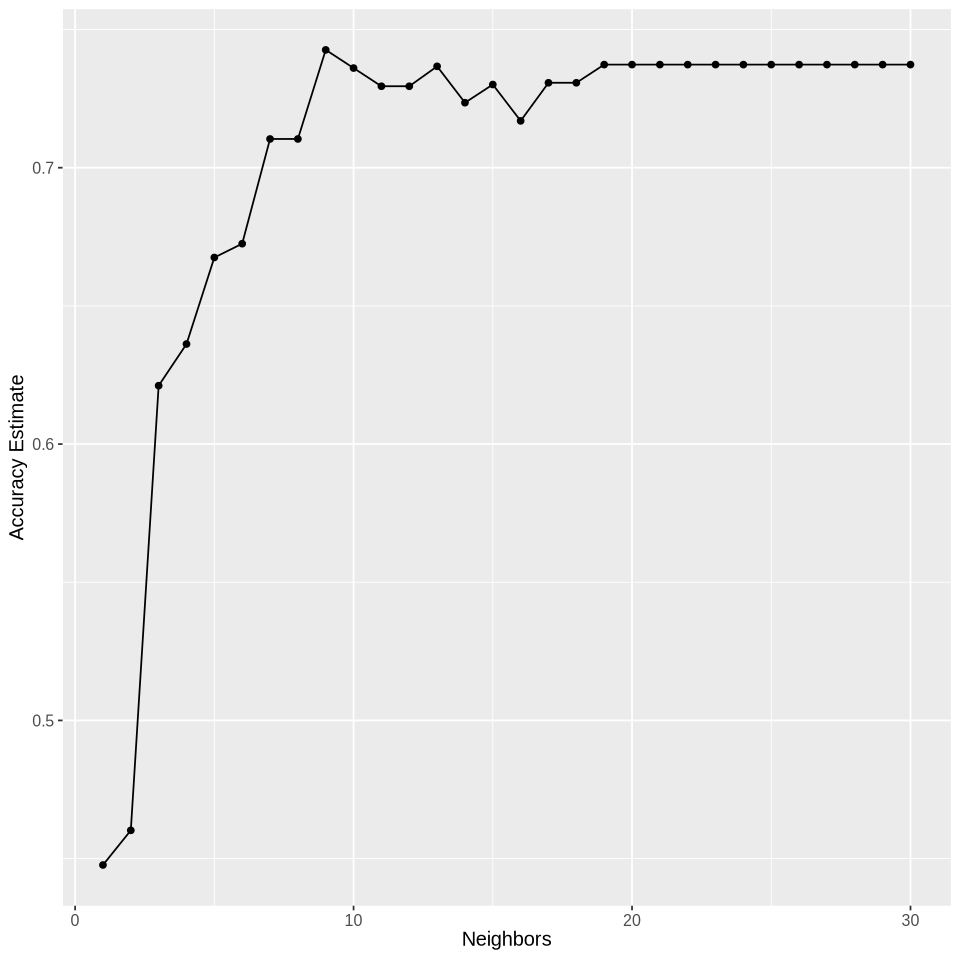

In [35]:
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    theme(text = element_text(size = 12))

accuracy_vs_k

---- picking best K ----

In [36]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)

best_k

[1] 9

---- tuning and fitting model ----

In [37]:
players_spec_tuned <- nearest_neighbor(weight_func = "rectangular", neighbors = best_k) |>
  set_engine("kknn") |>
  set_mode("classification")

players_fit <- workflow() |>
  add_recipe(players_recipe) |>
  add_model(players_spec_tuned) |>
  fit(data = players_train)

players_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
4 Recipe Steps

• step_impute_mean()
• step_dummy()
• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(9,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2371795
Best kernel: rectangular
Best k: 9

---- model accuracy, precision, and recall ----

In [38]:
players_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)

print("Model Levels:")
players_predictions |> pull(subscribe) |> levels()

print("Model Accuracy:")
players_predictions |>
    metrics(truth = subscribe, estimate = .pred_class) |>
    filter(.metric == "accuracy")

print("Model Precision:")
players_predictions |>
    precision(truth = subscribe, estimate = .pred_class, event_level = "second")

print("Model Recall:")
players_predictions |>
    recall(truth = subscribe, estimate = .pred_class, event_level = "second")

[1] "Model Levels:"


[1] "FALSE" "TRUE"

[1] "Model Accuracy:"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.725


[1] "Model Precision:"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
precision,binary,0.75


[1] "Model Recall:"


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
recall,binary,0.9310345


---- confusion matrix ----

In [39]:
confusion <- players_predictions |>
        conf_mat(truth = subscribe, estimate = .pred_class)

confusion

          Truth
Prediction FALSE TRUE
     FALSE     2    2
     TRUE      9   27

---- proportions ----

In [40]:
player_proportions <- players_train |>
    group_by(subscribe) |>
    summarize(n = n()) |>
    mutate(percent = 100*n/nrow(players_train))

player_proportions

subscribe,n,percent
<fct>,<int>,<dbl>
FALSE,41,26.28205
TRUE,115,73.71795


<h1><center><u>Discussion</u></center></h1>

<h1><center><u>References</u></center></h1>